## Import Necessary Libraries

In [1]:
import gdown
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from shutil import copyfile
import matplotlib.pyplot as plt
import sys
import tensorflow_hub as hub
from PIL import Image
sys.modules['Image'] = Image

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8283981779330595201
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10062135296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5111589785601335091
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## Prepare Dataset

In [3]:
# download_url = "https://drive.google.com/uc?export=download&id=16KiEYXwuOs8ZvEGLrjxpbg_sZn4L_8zP"
# destination_path = os.path.join(os.getcwd(), "data.zip")

# gdown.download(download_url, destination_path, quiet=False)
# with zipfile.ZipFile(destination_path, 'r') as zip_ref:
#     zip_ref.extractall("./data")

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=16KiEYXwuOs8ZvEGLrjxpbg_sZn4L_8zP
From (redirected): https://drive.google.com/uc?export=download&id=16KiEYXwuOs8ZvEGLrjxpbg_sZn4L_8zP&confirm=t&uuid=35b31368-26c2-43d9-ae18-e6962653c02e
To: c:\Users\User\OneDrive\Documents\Bangkit Moment\data.zip
100%|██████████| 57.3M/57.3M [00:16<00:00, 3.51MB/s]


In [2]:
IMAGE_SIZE = (224,224)

In [3]:
source_path = './data/Garbage_classification/'

source_path_besi = os.path.join(source_path, 'besi')
source_path_kaca = os.path.join(source_path, 'kaca')
source_path_kardus = os.path.join(source_path, 'kardus')
source_path_kertas = os.path.join(source_path, 'kertas')
source_path_organik = os.path.join(source_path, 'organik')
source_path_plastik = os.path.join(source_path, 'plastik')

print(f"There are {len(os.listdir(source_path_besi))} images of besi.")
print(f"There are {len(os.listdir(source_path_kaca))} images of kaca.")
print(f"There are {len(os.listdir(source_path_kardus))} images of kardus.")
print(f"There are {len(os.listdir(source_path_kertas))} images of kertas.")
print(f"There are {len(os.listdir(source_path_organik))} images of organik.")
print(f"There are {len(os.listdir(source_path_plastik))} images of plastik.")

There are 600 images of besi.
There are 600 images of kaca.
There are 600 images of kardus.
There are 600 images of kertas.
There are 600 images of organik.
There are 600 images of plastik.


In [4]:
root_dir = './data/garbage_training/'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  train_path = os.path.join(root_path, 'training')
  os.makedirs(train_path, exist_ok=True)
  os.makedirs(os.path.join(train_path, 'besi'), exist_ok=True)
  os.makedirs(os.path.join(train_path, 'kaca'), exist_ok=True)
  os.makedirs(os.path.join(train_path, 'kardus'), exist_ok=True)
  os.makedirs(os.path.join(train_path, 'kertas'), exist_ok=True)
  os.makedirs(os.path.join(train_path, 'organik'), exist_ok=True)
  os.makedirs(os.path.join(train_path, 'plastik'), exist_ok=True)

  validation_path = os.path.join(root_path, 'validation')
  os.makedirs(validation_path, exist_ok=True)    
  os.makedirs(os.path.join(validation_path, 'besi'), exist_ok=True)
  os.makedirs(os.path.join(validation_path, 'kaca'), exist_ok=True)
  os.makedirs(os.path.join(validation_path, 'kardus'), exist_ok=True)
  os.makedirs(os.path.join(validation_path, 'kertas'), exist_ok=True)
  os.makedirs(os.path.join(validation_path, 'organik'), exist_ok=True)
  os.makedirs(os.path.join(validation_path, 'plastik'), exist_ok=True)
  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print(f"The folder and file is already existe on the {root_dir}")

In [5]:
# Check current parent and child directory of root_dir
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

./data/garbage_training/training
./data/garbage_training/validation
./data/garbage_training/training\besi
./data/garbage_training/training\kaca
./data/garbage_training/training\kardus
./data/garbage_training/training\kertas
./data/garbage_training/training\organik
./data/garbage_training/training\plastik
./data/garbage_training/validation\besi
./data/garbage_training/validation\kaca
./data/garbage_training/validation\kardus
./data/garbage_training/validation\kertas
./data/garbage_training/validation\organik
./data/garbage_training/validation\plastik


In [6]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  filenames = os.listdir(SOURCE_DIR)

  random.shuffle(filenames)

  split_index = int(SPLIT_SIZE * len(filenames))

  training_filenames = filenames[:split_index]
  validation_filenames = filenames[split_index:]

  for filename in training_filenames:
    source = os.path.join(SOURCE_DIR, filename)
    destination = os.path.join(TRAINING_DIR, filename)
    shutil.copyfile(source, destination)

  for filename in validation_filenames:
    source = os.path.join(SOURCE_DIR, filename)
    destination = os.path.join(VALIDATION_DIR, filename)
    shutil.copyfile(source, destination)

In [7]:
BESI_SOURCE_DIR = "./data/Garbage_classification/besi/"
KACA_SOURCE_DIR = "./data/Garbage_classification/kaca/"
KARDUS_SOURCE_DIR = "./data/Garbage_classification/kardus/"
KERTAS_SOURCE_DIR = "./data/Garbage_classification/kertas/"
ORGANIK_SOURCE_DIR = "./data/Garbage_classification/organik/"
PLASTIK_SOURCE_DIR = "./data/Garbage_classification/plastik/"

TRAINING_DIR = "./data/garbage_training/training/"
VALIDATION_DIR = "./data/garbage_training/validation/"

TRAINING_BESI_DIR = os.path.join(TRAINING_DIR, "besi/")
VALIDATION_BESI_DIR = os.path.join(VALIDATION_DIR, "besi/")

TRAINING_KACA_DIR = os.path.join(TRAINING_DIR, "kaca/")
VALIDATION_KACA_DIR = os.path.join(VALIDATION_DIR, "kaca/")

TRAINING_KARDUS_DIR = os.path.join(TRAINING_DIR, "kardus/")
VALIDATION_KARDUS_DIR = os.path.join(VALIDATION_DIR, "kardus/")

TRAINING_KERTAS_DIR = os.path.join(TRAINING_DIR, "kertas/")
VALIDATION_KERTAS_DIR = os.path.join(VALIDATION_DIR, "kertas/")

TRAINING_ORGANIK_DIR = os.path.join(TRAINING_DIR, "organik/")
VALIDATION_ORGANIK_DIR = os.path.join(VALIDATION_DIR, "organik/")

TRAINING_PLASTIK_DIR = os.path.join(TRAINING_DIR, "plastik/")
VALIDATION_PLASTIK_DIR = os.path.join(VALIDATION_DIR, "plastik/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_BESI_DIR)) > 0:
  for file in os.scandir(TRAINING_BESI_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_KACA_DIR)) > 0:
  for file in os.scandir(TRAINING_KACA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_KARDUS_DIR)) > 0:
  for file in os.scandir(TRAINING_KARDUS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_KERTAS_DIR)) > 0:
  for file in os.scandir(TRAINING_KERTAS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_ORGANIK_DIR)) > 0:
  for file in os.scandir(TRAINING_ORGANIK_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_PLASTIK_DIR)) > 0:
  for file in os.scandir(TRAINING_PLASTIK_DIR):
    os.remove(file.path)

if len(os.listdir(VALIDATION_BESI_DIR)) > 0:
  for file in os.scandir(VALIDATION_BESI_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_KACA_DIR)) > 0:
  for file in os.scandir(VALIDATION_KACA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_KARDUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_KARDUS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_KERTAS_DIR)) > 0:
  for file in os.scandir(VALIDATION_KERTAS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_ORGANIK_DIR)) > 0:
  for file in os.scandir(VALIDATION_ORGANIK_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_PLASTIK_DIR)) > 0:
  for file in os.scandir(VALIDATION_PLASTIK_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .8
split_data(BESI_SOURCE_DIR, TRAINING_BESI_DIR, VALIDATION_BESI_DIR, split_size)
split_data(KACA_SOURCE_DIR, TRAINING_KACA_DIR, VALIDATION_KACA_DIR, split_size)
split_data(KARDUS_SOURCE_DIR, TRAINING_KARDUS_DIR, VALIDATION_KARDUS_DIR, split_size)
split_data(KERTAS_SOURCE_DIR, TRAINING_KERTAS_DIR, VALIDATION_KERTAS_DIR, split_size)
split_data(ORGANIK_SOURCE_DIR, TRAINING_ORGANIK_DIR, VALIDATION_ORGANIK_DIR, split_size)
split_data(PLASTIK_SOURCE_DIR, TRAINING_PLASTIK_DIR, VALIDATION_PLASTIK_DIR, split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"Original besi directory has {len(os.listdir(BESI_SOURCE_DIR))} images")
print(f"Original kaca directory has {len(os.listdir(KACA_SOURCE_DIR))} images")
print(f"Original kardus directory has {len(os.listdir(KARDUS_SOURCE_DIR))} images")
print(f"Original kertas directory has {len(os.listdir(KERTAS_SOURCE_DIR))} images")
print(f"Original organik directory has {len(os.listdir(ORGANIK_SOURCE_DIR))} images")
print(f"Original plastik directory has {len(os.listdir(PLASTIK_SOURCE_DIR))} images")
print()

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_BESI_DIR))} images of besi for training")
print(f"There are {len(os.listdir(TRAINING_KACA_DIR))} images of kaca for training")
print(f"There are {len(os.listdir(TRAINING_KARDUS_DIR))} images of kardus for training")
print(f"There are {len(os.listdir(TRAINING_KERTAS_DIR))} images of kertas for training")
print(f"There are {len(os.listdir(TRAINING_ORGANIK_DIR))} images of organik for training")
print(f"There are {len(os.listdir(TRAINING_PLASTIK_DIR))} images of plastik for training")
print(f"There are {len(os.listdir(VALIDATION_BESI_DIR))} images of besi for validation")
print(f"There are {len(os.listdir(VALIDATION_KACA_DIR))} images of kaca for validation")
print(f"There are {len(os.listdir(VALIDATION_KARDUS_DIR))} images of kardus for validation")
print(f"There are {len(os.listdir(VALIDATION_KERTAS_DIR))} images of kertas for validation")
print(f"There are {len(os.listdir(VALIDATION_ORGANIK_DIR))} images of organik for validation")
print(f"There are {len(os.listdir(VALIDATION_PLASTIK_DIR))} images of plastik for validation")

Original besi directory has 600 images
Original kaca directory has 600 images
Original kardus directory has 600 images
Original kertas directory has 600 images
Original organik directory has 600 images
Original plastik directory has 600 images

There are 480 images of besi for training
There are 480 images of kaca for training
There are 480 images of kardus for training
There are 480 images of kertas for training
There are 480 images of organik for training
There are 480 images of plastik for training
There are 120 images of besi for validation
There are 120 images of kaca for validation
There are 120 images of kardus for validation
There are 120 images of kertas for validation
There are 120 images of organik for validation
There are 120 images of plastik for validation


In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1. / 255,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      rotation_range=30,
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      brightness_range=(0.8, 1.2),
                                      fill_mode="nearest")
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))
  
  validation_datagen = ImageDataGenerator(rescale=1./255)
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 2880 images belonging to 6 classes.
Found 720 images belonging to 6 classes.


## Model with Transfer Learning

In [14]:
# Load the base model
base_model = VGG16(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

In [37]:
def create_vgg_model(base_model, num_classes=6):
  # Freeze previous model
  for layer in base_model.layers:
    layer.trainable = False
  
  # Create the classifier model
  model = tf.keras.models.Sequential()
  model.add(base_model)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
  
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
  return model

In [38]:
import tensorflow as tf
tf.test.is_gpu_available() #should return True 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [39]:
model = create_vgg_model(base_model)

history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/10
299/299 [==============================] - 34s 110ms/step - loss: 1.2687 - accuracy: 0.5510 - val_loss: 0.7704 - val_accuracy: 0.6617
Epoch 2/10
299/299 [==============================] - 32s 108ms/step - loss: 0.8720 - accuracy: 0.6402 - val_loss: 0.7567 - val_accuracy: 0.6867
Epoch 3/10
299/299 [==============================] - 32s 107ms/step - loss: 0.8471 - accuracy: 0.6385 - val_loss: 0.6460 - val_accuracy: 0.7417
Epoch 4/10
299/299 [==============================] - 33s 110ms/step - loss: 0.7417 - accuracy: 0.6904 - val_loss: 0.6035 - val_accuracy: 0.7317
Epoch 5/10
299/299 [==============================] - 32s 106ms/step - loss: 0.7279 - accuracy: 0.7025 - val_loss: 0.5482 - val_accuracy: 0.7867
Epoch 6/10
299/299 [==============================] - 33s 110ms/step - loss: 0.6679 - accuracy: 0.7197 - val_loss: 0.5217 - val_accuracy: 0.8067
Epoch 7/10
299/299 [==============================] - 32s 107ms/step - loss: 0.6764 - accuracy: 0.7293 - val_loss: 0.5611 - val_ac

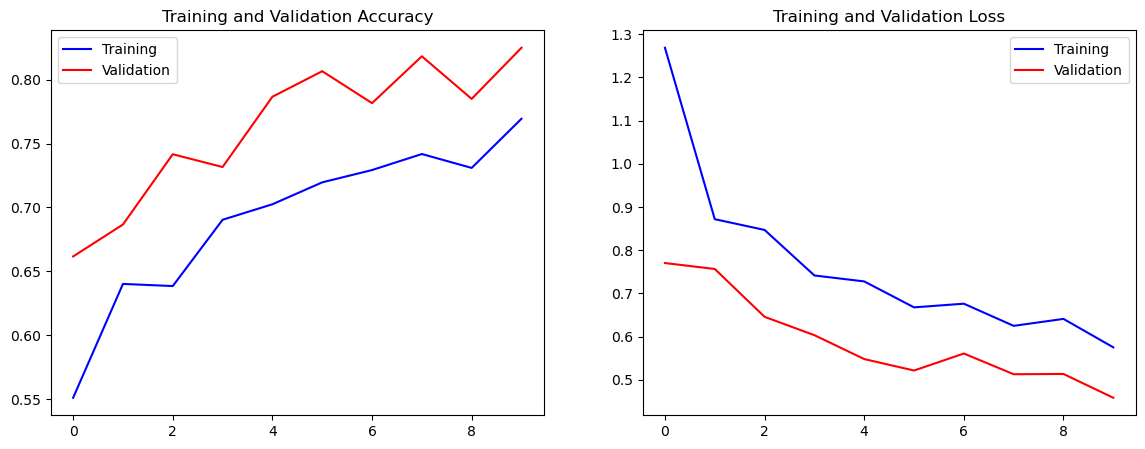

In [40]:
plt.figure(figsize=(14, 5))

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Plot visualization
plt.subplot(1, 2, 1)
accuracy_plot, = plt.plot(epochs, accuracy, color="blue")
val_accuracy_plot, = plt.plot(epochs, val_accuracy, color="red")
plt.title('Training and Validation Accuracy')
plt.legend([accuracy_plot, val_accuracy_plot],['Training', 'Validation'])


plt.subplot(1, 2, 2)
loss_plot, = plt.plot(epochs, loss, color="blue")
val_loss_plot, = plt.plot(epochs, val_loss, color="red")
plt.title('Training and Validation Loss')
plt.legend([loss_plot, val_loss_plot],['Training', 'Validation'])

In [ ]:
model.save('model_tl_resnet50.h5')

## Model with Feature Vector

In [10]:
MODULE_HANDLE = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
feature_extractor = hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE + (3,)) # Default trainable = False

In [15]:
# V3
def create_model(num_classes=6):
  model = tf.keras.models.Sequential([ 
    feature_extractor,
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(num_classes, activation='softmax')
  ]) 
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
  return model

In [20]:
# V3
def create_model(num_classes=6):
  model = tf.keras.models.Sequential([ 
    feature_extractor,
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
  ]) 
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.00025),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
  return model

In [22]:
model = create_model()

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
90/90 [==============================] - 29s 309ms/step - loss: 1.2299 - accuracy: 0.5240 - val_loss: 0.7259 - val_accuracy: 0.7681
Epoch 2/15
90/90 [==============================] - 27s 304ms/step - loss: 0.7500 - accuracy: 0.7295 - val_loss: 0.5394 - val_accuracy: 0.8361
Epoch 3/15
90/90 [==============================] - 29s 322ms/step - loss: 0.5932 - accuracy: 0.7920 - val_loss: 0.4485 - val_accuracy: 0.8569
Epoch 4/15
90/90 [==============================] - 29s 318ms/step - loss: 0.5246 - accuracy: 0.8236 - val_loss: 0.4176 - val_accuracy: 0.8736
Epoch 5/15
90/90 [==============================] - 29s 317ms/step - loss: 0.4725 - accuracy: 0.8451 - val_loss: 0.3884 - val_accuracy: 0.8722
Epoch 6/15
90/90 [==============================] - 28s 314ms/step - loss: 0.4256 - accuracy: 0.8538 - val_loss: 0.3698 - val_accuracy: 0.8847
Epoch 7/15
90/90 [==============================] - 28s 313ms/step - loss: 0.3892 - accuracy: 0.8694 - val_loss: 0.3554 - val_accuracy: 0.8847

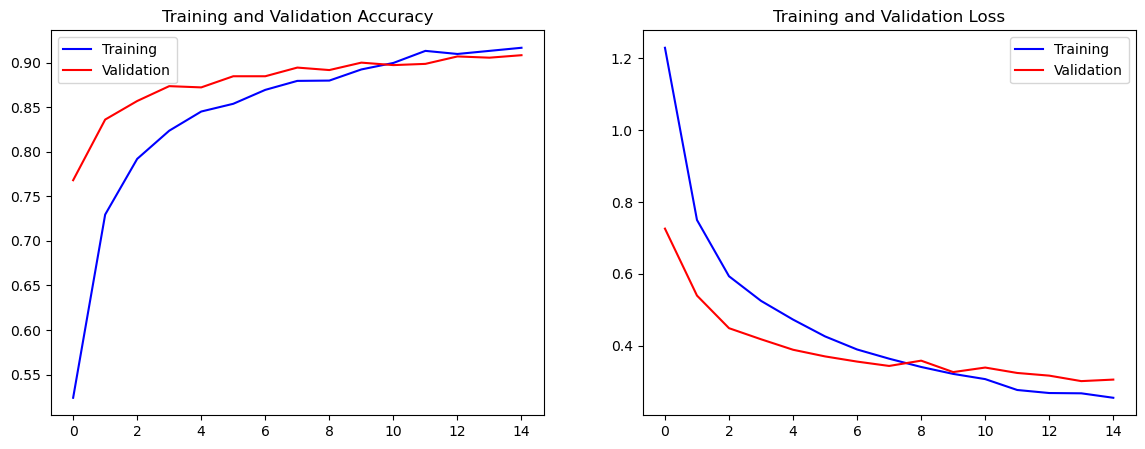

In [23]:
plt.figure(figsize=(14, 5))

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Plot visualization
plt.subplot(1, 2, 1)
accuracy_plot, = plt.plot(epochs, accuracy, color="blue")
val_accuracy_plot, = plt.plot(epochs, val_accuracy, color="red")
plt.title('Training and Validation Accuracy')
plt.legend([accuracy_plot, val_accuracy_plot],['Training', 'Validation'])


plt.subplot(1, 2, 2)
loss_plot, = plt.plot(epochs, loss, color="blue")
val_loss_plot, = plt.plot(epochs, val_loss, color="red")
plt.title('Training and Validation Loss')
plt.legend([loss_plot, val_loss_plot],['Training', 'Validation'])

In [24]:
model.evaluate(validation_generator)

23/23 [==============================] - 2s 58ms/step - loss: 0.3052 - accuracy: 0.9083


[0.30524304509162903, 0.9083333611488342]

In [26]:
model.save('model_fv_resnet50_v6.h5')

## Initial Model without Feature Vector or Transfer Learning

In [46]:
def create_model():
  model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding="same", input_shape=(225, 225, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
  ]) 
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
  return model

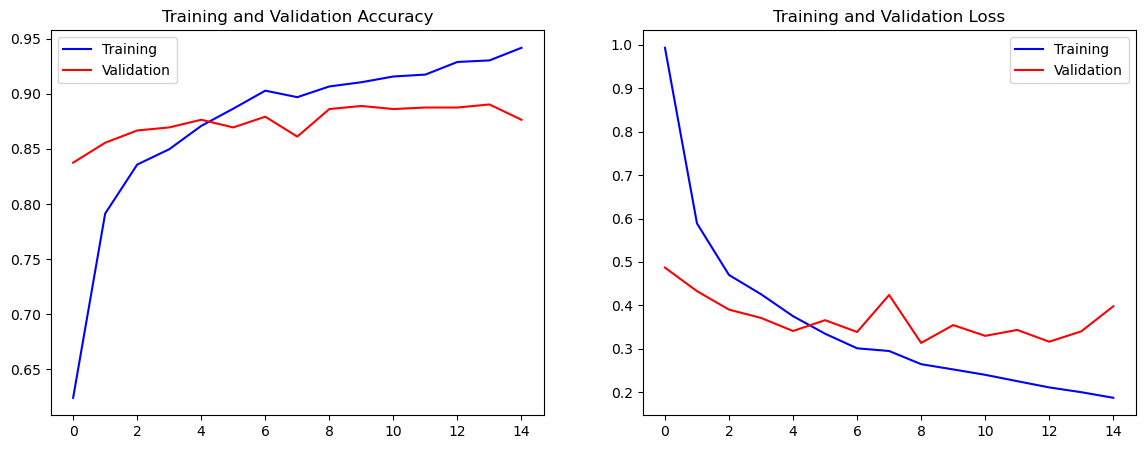

In [45]:
plt.figure(figsize=(14, 5))

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Plot visualization
plt.subplot(1, 2, 1)
accuracy_plot, = plt.plot(epochs, accuracy, color="blue")
val_accuracy_plot, = plt.plot(epochs, val_accuracy, color="red")
plt.title('Training and Validation Accuracy')
plt.legend([accuracy_plot, val_accuracy_plot],['Training', 'Validation'])


plt.subplot(1, 2, 2)
loss_plot, = plt.plot(epochs, loss, color="blue")
val_loss_plot, = plt.plot(epochs, val_loss, color="red")
plt.title('Training and Validation Loss')
plt.legend([loss_plot, val_loss_plot],['Training', 'Validation'])

In [ ]:
model.save('initial_model.h5')

## Check Validation Pictures and the Corresponding Labels

## Unused Codes

In [24]:
# def identity_block(input_tensor, filter):
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(input_tensor)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)

#     x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)

#     x = tf.keras.layers.Add()([x, input_tensor])     
#     x = tf.keras.layers.Activation('relu')(x)
#     return x

# def resnet(shape=(150, 150, 3), num_class=6):
#     # Input Block
#     x_input = tf.keras.layers.Input(shape)
#     x = tf.keras.layers.Conv2D(64, 7, padding='same')(x_input)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     x = tf.keras.layers.MaxPool2D((3, 3))(x)

#     # Identity Block
#     x = identity_block(x, 64)
#     x = identity_block(x, 64)
#     x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dense(num_class, activation='softmax')(x)
#     return tf.keras.models.Model(inputs = x_input, outputs = x, name = "1StagesResNet")

# model = resnet(shape=(150, 150, 3), num_class=6)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy']) 